In [26]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter
import time

%matplotlib inline

### Functions

In [2]:
# hyperparameters
X_shift = 65 # cooridnates shifted from base point
Y_shift = 70 

X_min = 0
X_max = 125
Y_min = 0
Y_max = 120

dire_base_x = 111
dire_base_y = 104
dire_base_r2 = 26**2

radian_base_x = 10
radian_base_y = 8
radian_base_r2 = 26**2

top_vert_x = 13
top_hor_y = 104

bot_vert_x = 112
bot_hor_y = 8

mg = 7
top_vert_margin = mg
top_hor_margin = mg
bot_vert_margin = mg 
bot_hor_margin = mg

mid_margin = mg + 2

mid_coef_a = 0.95
mid_coef_b = -3.71

In [3]:
def get_position(x, y, team):
    c = 'forest'
        
    # mid lane
    if (abs(y - mid_coef_b - mid_coef_a*x) < mid_margin):
        c = 'mid'
            
        
    if (x > top_vert_x - top_vert_margin and x < top_vert_x + top_vert_margin) or \
    (y > top_hor_y - top_hor_margin and y < top_hor_y + top_hor_margin):
        if team == 0:
            c = 'top' # top lane for radian
        else:
            c = 'bot' # bot lane for dire
                
    # bot lane for radian
    elif (x > bot_vert_x - bot_vert_margin and x < bot_vert_x + bot_vert_margin) or \
    (y > bot_hor_y - bot_hor_margin and y < bot_hor_y + bot_hor_margin):
        if team == 0:
            c = 'bot' # bot lane for radian
        else:
            c = 'top' # top lane for dire
        
    # Radian base
    if ((x-radian_base_x)**2+(y-radian_base_y)**2 < radian_base_r2):
        if team == 0:
            c = 'base' # base for radian
        else:
            c = 'base_enemy' # enimy base for dire
                
    # Dire base
    if ((x-dire_base_x)**2+(y-dire_base_y)**2 < dire_base_r2):
        if team == 0:
            c = 'base_enemy' # enemy base for radian
        else:
            c = 'base' # base for dire
    
    return c

def position_over_time(series, x_ind=1, y_ind=2, life_state_ind=3, slot_ind=4):
    res = []
    team = 0 if series[0][slot_ind] <5 else 1 # 0 - radian, 1 - dire
    for tick in series:
        x = tick[x_ind]
        y = tick[y_ind]
        c = get_position(x, y, team)
        if tick[life_state_ind]!=0:
            c = 'dead'
        res.append([tick[0], c])
    return res

In [6]:
def calc_stats(heroes, team):
    size = max([heroes[i].time.max() for i in range(len(heroes))])

    stat = {
        'gold':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'xp':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'deaths':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'kills':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        }
    }

    def diff(new, old):
        t = new - old
        return t, new

    for h in heroes:
        base_gold = 0
        base_xp = 0
        base_kills = 0
        base_deaths = 0

        for index, row in enumerate(h.itertuples()):
            g = row.gold
            xp = row.xp
            k = row.kills
            d = row.deaths

            # compute difference
            g, base_gold = diff(g, base_gold)
            xp, base_xp = diff(xp, base_xp)
            k, base_kills = diff(k, base_kills)
            d, base_deaths = diff(d, base_deaths)

            key = get_position(row.x, row.y, team)


            stat['gold'][key][index] += g
            stat['xp'][key][index] += xp
            stat['kills'][key][index] += k
            stat['deaths'][key][index] += d

    return stat

In [7]:
def calc_absolete(stat, heroes):
    size = max([heroes[i].time.max() for i in range(len(heroes))])

    stat_absolete = {
        'gold':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'xp':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'deaths':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        },
        'kills':{
            'forest': np.zeros(size),
            'top':np.zeros(size),
            'bot':np.zeros(size),
            'mid':np.zeros(size),
            'base_enemy':np.zeros(size),
            'base':np.zeros(size)
        }
    }

    for param in stat.keys():
        for zone in stat[param].keys():
            for i in range(len(stat[param][zone])): #(stat[param][zone][1:]):
                stat_absolete[param][zone][i] = stat[param][zone][i] + stat_absolete[param][zone][i-1]
    return stat_absolete

In [11]:
def get_presence(hero_zone_ch, zone, label):
    presence = []
    time = []
    for i in hero_zone_ch.itertuples():
        if i.zone == zone:
            presence.append(label)
            time.append(i.time)
            
    return presence, time

def get_diff(stat1, stat2, zone, param):
    diff = []
    for i in range(len(stat[param][zone])):
        diff.append(stat1[param][zone][i] - stat2[param][zone][i])
    return diff

def get_stat_diff(stat1, stat2):

    stat_absolete = {
        'gold':{
            'forest':[],
            'top':[],
            'bot':[],
            'mid':[],
            'base_enemy':[],
            'base':[]
        },
        'xp':{
            'forest':[],
            'top':[],
            'bot':[],
            'mid':[],
            'base_enemy':[],
            'base':[]
        },
        'deaths':{
            'forest':[],
            'top':[],
            'bot':[],
            'mid':[],
            'base_enemy':[],
            'base':[]
        },
        'kills':{
            'forest':[],
            'top':[],
            'bot':[],
            'mid':[],
            'base_enemy':[],
            'base':[]
        }
    }
    
    for param in stat1.keys():
        for zone in stat1[param].keys():
            for i in range(len(stat1[param][zone])):
                stat_absolete[param][zone].append(stat1[param][zone][i] - stat2[param][zone][i])
                
    return stat_absolete

### Pipeline

In [117]:
dir_name = 'replays_usual'
# dir_name = 'test_fold'
keys = ['time', 'unit', 'slot', 'x', 'y', 'xp', 'kills','deaths', 'level', 'gold', 'life_state']

win_stat = []
lose_stat = []

count = 0

for filename in os.listdir(dir_name):
    start = time.time()
    json_data=open(dir_name + '/'+filename).read()
    
    data = json.loads(json_data) 
    
    # Choose win team
    for r in reversed(data[:]):
        if 'radiant_win' in r.keys():
            win_team = 0 if r['radiant_win']==1 else 1
            break
            
    
    # Collect all data, relevant to heroes on the map
    heroTraces = []
    for r in data[:]:
        if 'unit' in r.keys():
            if 'x' in r.keys():
                c = Counter()
                for k in keys:
                    c[k] = r[k]
                c['x'] = c['x'] - X_shift
                c['y'] = c['y'] - X_shift
                heroTraces.append(dict(c))
    game_df = pd.DataFrame(heroTraces)
    
    # Separate data for each hero
    hero = []
    for i in range(10):
        hero.append(game_df[game_df.slot==i])
        
    # Calculate zone stat for each position over time        
    radian_stat = calc_stats(hero[:5], team=0)
    radian_stat_absolete = calc_absolete(radian_stat, hero[:5])

    dire_stat = calc_stats(hero[5:], team=1)
    dire_stat_absolete = calc_absolete(dire_stat, hero[5:])
    
    
    win_t = radian_stat_absolete if win_team == 0 else dire_stat_absolete
    lose_t = radian_stat_absolete if win_team == 1 else dire_stat_absolete
    
    win_diff = get_stat_diff(win_t, lose_t)
    lose_diff = get_stat_diff(lose_t, win_t)  
        
    win_stat.append(win_diff)
    lose_stat.append(lose_diff)
    
    end = time.time()
    print ('File: {} parsed with time = {}'.format(filename, end - start))

File: 3839284334_1368498524.json parsed with time = 3.2273359298706055
File: 3839288666_706072081.json parsed with time = 2.748090982437134
File: 3839293801_1131130612.json parsed with time = 2.179636001586914
File: 3839297424_79091828.json parsed with time = 2.354423999786377
File: 3839297529_412007562.json parsed with time = 2.103969097137451
File: 3839304511_1454369332.json parsed with time = 1.981220006942749
File: 3839305762_1488873721.json parsed with time = 1.8830959796905518
File: 3839305901_1192216448.json parsed with time = 1.7451319694519043
File: 3839306023_1028553070.json parsed with time = 1.8212029933929443
File: 3839307310_468813807.json parsed with time = 1.7622439861297607
File: 3839307338_1846269886.json parsed with time = 1.7370579242706299
File: 3839307764_743767757.json parsed with time = 1.7651288509368896
File: 3839307920_1163960667.json parsed with time = 1.7891180515289307
File: 3839308538_994688469.json parsed with time = 1.7597639560699463
File: 3839308758_1

In [118]:
import pickle
afile = open('usual_stat', 'wb')
pickle.dump(win_stat, afile)
afile.close()

In [126]:
usual_players_stat = pickle.load( open( "usual_stat", "rb" ) )
pro_players_stat = pickle.load( open( "pro_stat", "rb" ) )

In [131]:
def get_avg_stat(www):
    avg_win = {
        'gold':{
            'top':[],
            'bot':[],
            'mid':[]
        },
        'xp':{
            'top':[],
            'bot':[],
            'mid':[]
        },
        'deaths':{
            'top':[],
            'bot':[],
            'mid':[]
        },
        'kills':{
            'top':[],
            'bot':[],
            'mid':[]
        }
    }

    size = max([len(i['gold']['top']) for i in www])

    for param in avg_win.keys():
        for zone in zones:
            for i in range(size):
                l = [w[param][zone][i] for w in www if i < len(w[param][zone])]
                avg_win[param][zone].append(sum(l) / float(len(l)))
            print("zone - {}, param - {} finished".format(zone, param))
    return avg_win

In [132]:
us_avg = get_avg_stat(usual_players_stat)
pro_avg = get_avg_stat(pro_players_stat)

zone - top, param - deaths finished
zone - bot, param - deaths finished
zone - mid, param - deaths finished
zone - top, param - gold finished
zone - bot, param - gold finished
zone - mid, param - gold finished
zone - top, param - kills finished
zone - bot, param - kills finished
zone - mid, param - kills finished
zone - top, param - xp finished
zone - bot, param - xp finished
zone - mid, param - xp finished
zone - top, param - deaths finished
zone - bot, param - deaths finished
zone - mid, param - deaths finished
zone - top, param - gold finished
zone - bot, param - gold finished
zone - mid, param - gold finished
zone - top, param - kills finished
zone - bot, param - kills finished
zone - mid, param - kills finished
zone - top, param - xp finished
zone - bot, param - xp finished
zone - mid, param - xp finished


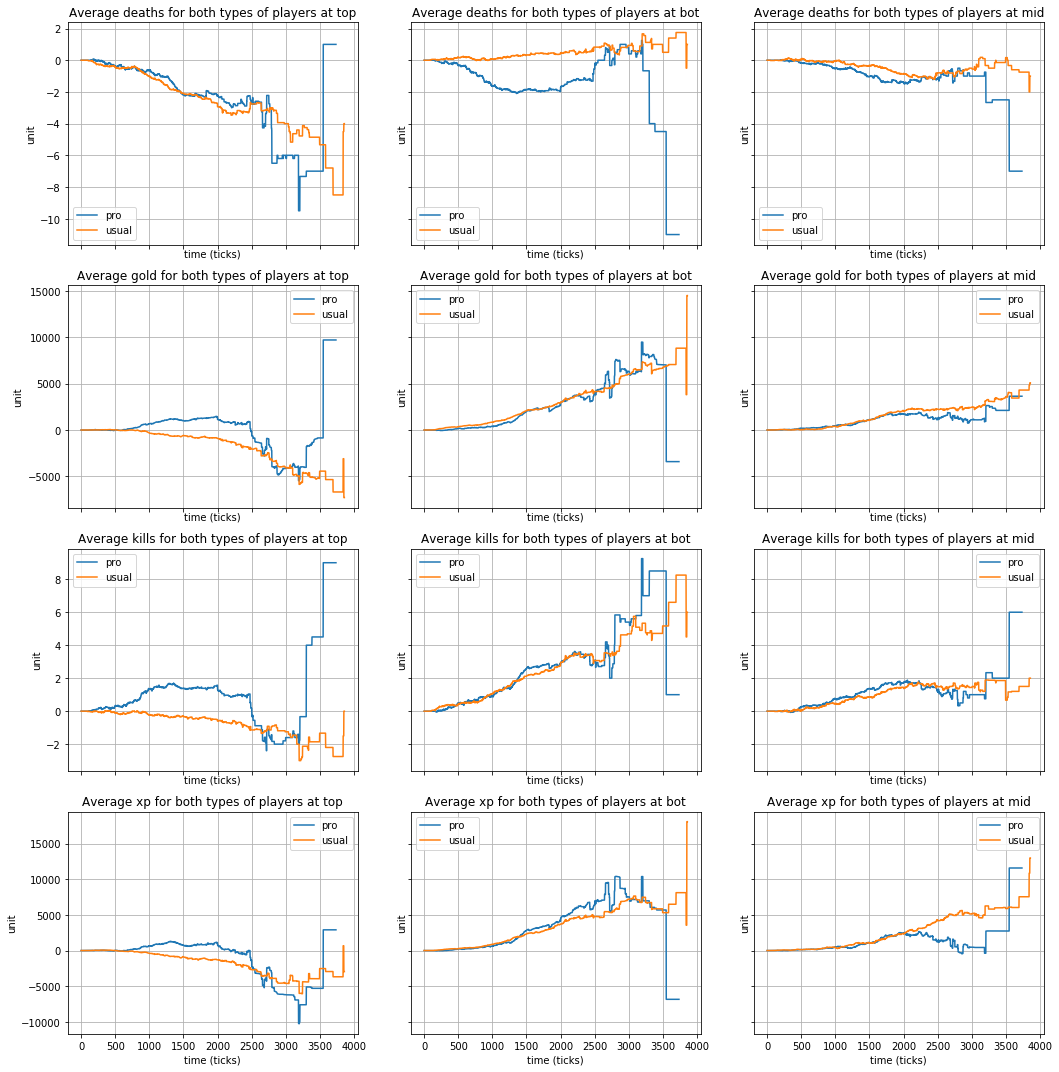

In [142]:
fig, ax = plt.subplots(4,3,figsize=(15,15), sharex='col', sharey='row')
ax = ax.ravel()
ind = 0

for param in avg_win.keys():
    for zone in zones:
        ax1 = ax[ind]
        ind+=1
        
        ax1.plot(us_avg[param][zone], label='pro')
        ax1.plot(pro_avg[param][zone], label='usual')
        ax1.set_ylabel('unit')
        ax1.set_xlabel('time (ticks)')
        ax1.set_title('Average ' + param + ' for both types of players at '+ zone )
        ax1.legend()
        ax1.grid(True)


for ax_ in ax:
    for tk in ax_.get_yticklabels():
        tk.set_visible(True)
    for tk in ax_.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()
plt.savefig('comparison.png')
plt.show()